In [1]:
from pynq import Overlay
from pynq import MMIO
from pynq import allocate
import pynq.lib.dma
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import time

In [2]:
base = Overlay("./design_1.bit")
dma = base.axi_dma_0
registers = base.bg_0.register_map

In [3]:
src = cv2.imread("horse_noised.png", cv2.IMREAD_GRAYSCALE)
print(src.shape)

(1080, 1920)


In [4]:
height = 1080
width = 1920
input_buffer = allocate(shape=(height,width), dtype=np.uint32, cacheable=False)
output_buffer = allocate(shape=(height,width), dtype=np.uint32, cacheable=False)
input_buffer[:] = src[:height, :width]
input_buffer.flush()

In [5]:
registers.CTRL.AP_START = 1
registers.CTRL.AUTO_RESTART = 1
dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)

In [6]:
dma.sendchannel.wait()
dma.recvchannel.wait()

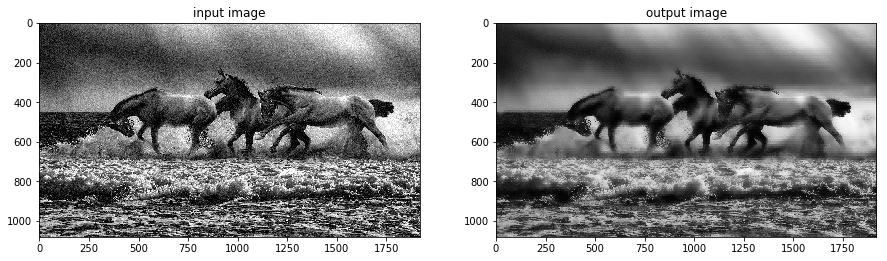

In [7]:
cv2.imwrite('horse_filtered.png', output_buffer.astype(np.uint8))

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(src, cmap = "gray")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(output_buffer, cmap="gray")
plt.title("output image")
plt.show()

In [8]:
SIZE = height*width
LOOP = 100
t0 = time.time()
for l in range(LOOP):
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

t1 = time.time()
print("Total elapsed time:", t1-t0, "s")
print("Frames per second:", LOOP/(t1-t0), "fps")
print("Elapsed time per picture:", ((t1-t0) / LOOP) * 1000, "ms")
print("Elapsed time per pixel:", ((t1-t0) / (SIZE*LOOP)) * 1000 * 1000 * 1000, "ns")
print("Throughput:", (SIZE*LOOP) / 1024 / 1024 / (t1-t0), "MBps")

Total elapsed time: 1.0090234279632568 s
Frame per second: 99.10572661514205 fps
Elapsed time per picture: 10.090234279632568 ms
Elapsed time per pixel: 4.8660466240512 ns
Throughput: 195.9854456988893 MBps
